In [ ]:
# input: 60 days + 5 days

#output: inflection point date or false

In [1]:
pip intall spicy

ERROR: unknown command "intall" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from typing import Union, Sequence
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_timeseries_sklearn(series):
    series = np.asarray(series).reshape(-1, 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(series).flatten()


def smooth_timeseries(
    series: Union[Sequence[float], np.ndarray],
    window_length: int = 31,
    polyorder: int = 3
) -> np.ndarray:
    """
    Apply Savitzky-Golay smoothing filter to a 1D time series.

    Args:
        series: Sequence of floats representing the time series data.
        window_length: Size of the filter window; must be odd and > polyorder.
        polyorder: Order of the polynomial to fit; must be less than window_length.

    Returns:
        Smoothed time series as a NumPy array.
    """
    series = np.asarray(series)

    if series.ndim != 1:
        raise ValueError("Input time series must be 1-dimensional.")

    if window_length % 2 == 0:
        raise ValueError("window_length must be odd.")
    
    if window_length < polyorder + 2:
        raise ValueError("window_length must be at least polyorder + 2.")
    
    if window_length > len(series):
        raise ValueError("window_length cannot be greater than the length of the series.")

    smoothed = savgol_filter(series, window_length, polyorder)
    return smoothed


# Logistic function for VI curve fitting
def logistic(t, a, b, c, d):
    return c / (1 + np.exp(a + b * t)) + d

# Derivative of curvature change (rate of change of curvature KV)
def curvature(t, a, b, c, d):
    z = np.exp(a + b * t)
    denom = ((1+z)**4 + (b*c*z)**2)**(3/2)
    num = (b**2) * c * z * (1-z) * ((1+z)**3)
    return num / denom


def curvature_rate_of_change(t, a, b, c, d):
    z = np.exp(a + b * t)
    z1=1-z
    z2=1+z
    z3= (b*c*z)**2
    partone_num= 3*z*(1-z)*((1+z)**3)  *   (2* (1+z)**3 + ((b**2)*(c**2)*z))
    partone_denom=((1+z)**4 + (z3))**(5/2)

    parttwo_num= (1+z)**2 * (1+2*z-5*z**2)
    parttwo_denom= ((1+z)**4+z3)**(3/2)
    
    difference = (partone_num/partone_denom) - (parttwo_num/parttwo_denom)
    return b**3*c*z*difference


# Identify segments of increasing/decreasing VI
def identify_segments(vi, window=180):
    trend = np.sign(np.convolve(np.diff(vi), np.ones(window), mode='same'))
    segments = []
    start = 0
    for i in range(1, len(trend)):
        if trend[i] != trend[i-1]:
            segments.append((start, i))
            start = i
    segments.append((start, len(vi)-1))
    print(segments)
    return segments

# Detect SOS and EOS from curvature extrema
def detect_transition_dates(t, vi):
    t = np.array(t)
    vi = np.array(vi)
    vi = smooth_timeseries(vi)

    
    segments = identify_segments(vi)
    print('found ', len(segments), 'segments')
    sos_eos_dates = []
    K_ts = []
    for (start, end) in segments:
        if end - start < 30:
            continue  # Skip short segments

        t_seg = t[start:end]
        vi_seg = vi[start:end]

        # Initial guess for parameters
        p0 = [-5, 0.1, max(vi_seg)-min(vi_seg), min(vi_seg)]
        try:
            popt, _ = curve_fit(logistic, t_seg, vi_seg, p0, maxfev=10000)
            kv = curvature_rate_of_change(t_seg, *popt)
            K_ts.append(kv)

            # Detect local extrema in rate of change of curvature
            extrema_indices = argrelextrema(kv, np.greater)[0]
            for idx in extrema_indices:
                sos_eos_dates.append(t_seg[idx])
        except Exception:
            continue

    return sorted(sos_eos_dates), vi, kv

# Detect SOS and EOS from curvature extrema
def transition_dates(t, vi):
    t = np.array(t)
    vi = np.array(vi)
    vi = smooth_timeseries(vi)

    
    segments = identify_segments(vi)
    print('found ', len(segments), 'segments')
    sos_eos_dates = []
    K_ts = []
    pops=[]
    for (start, end) in segments:
        t_seg = t[start:end]
        vi_seg = vi[start:end]
        # Initial guess for parameters
        p0 = [-5, 0.1, max(vi_seg)-vi_seg[0], vi_seg[0]]
        try:
            popt, _ = curve_fit(logistic, t, vi, p0, maxfev=100000)
            kv = curvature_rate_of_change(t_seg, *popt)
            K_ts.append(kv)
            pops.append(popt)
            # Detect local extrema in rate of change of curvature
            extrema_indices = argrelextrema(kv, np.greater)[0]
            for idx in extrema_indices:
                sos_eos_dates.append(t_seg[idx])
        except Exception:
            raise 'error'
    return sorted(sos_eos_dates), popt,  K_ts



In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from typing import Union, Sequence
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_timeseries_sklearn(series):
    series = np.asarray(series).reshape(-1, 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(series).flatten()


def smooth_timeseries(
    series: Union[Sequence[float], np.ndarray],
    window_length: int = 31,
    polyorder: int = 3
) -> np.ndarray:
    """
    Apply Savitzky-Golay smoothing filter to a 1D time series.

    Args:
        series: Sequence of floats representing the time series data.
        window_length: Size of the filter window; must be odd and > polyorder.
        polyorder: Order of the polynomial to fit; must be less than window_length.

    Returns:
        Smoothed time series as a NumPy array.
    """
    series = np.asarray(series)

    if series.ndim != 1:
        raise ValueError("Input time series must be 1-dimensional.")

    if window_length % 2 == 0:
        raise ValueError("window_length must be odd.")
    
    if window_length < polyorder + 2:
        raise ValueError("window_length must be at least polyorder + 2.")
    
    if window_length > len(series):
        raise ValueError("window_length cannot be greater than the length of the series.")

    smoothed = savgol_filter(series, window_length, polyorder)
    return smoothed


# Logistic function for VI curve fitting
def logistic(t, a, b, c, d):
    return c / (1 + np.exp(a + b * t)) + d

# Derivative of curvature change (rate of change of curvature KV)
def curvature(t, a, b, c, d):
    z = np.exp(a + b * t)
    denom = ((1+z)**4 + (b*c*z)**2)**(3/2)
    num = (b**2) * c * z * (1-z) * ((1+z)**3)
    return num / denom


def curvature_rate_of_change(t, a, b, c, d):
    z = np.exp(a + b * t)
    z1=1-z
    z2=1+z
    z3= (b*c*z)**2
    partone_num= 3*z*(1-z)*((1+z)**3)  *   (2* (1+z)**3 + ((b**2)*(c**2)*z))
    partone_denom=((1+z)**4 + (z3))**(5/2)

    parttwo_num= (1+z)**2 * (1+2*z-5*z**2)
    parttwo_denom= ((1+z)**4+z3)**(3/2)
    
    difference = (partone_num/partone_denom) - (parttwo_num/parttwo_denom)
    return b**3*c*z*difference


# Identify segments of increasing/decreasing VI
def identify_segments(vi, window=180):
    trend = np.sign(np.convolve(np.diff(vi), np.ones(window), mode='same'))
    segments = []
    start = 0
    for i in range(1, len(trend)):
        if trend[i] != trend[i-1]:
            segments.append((start, i))
            start = i
    segments.append((start, len(vi)-1))
    print(segments)
    return segments

# Detect SOS and EOS from curvature extrema
def detect_transition_dates(t, vi):
    t = np.array(t)
    vi = np.array(vi)
    vi = smooth_timeseries(vi)

    
    segments = identify_segments(vi)
    print('found ', len(segments), 'segments')
    sos_eos_dates = []
    K_ts = []
    for (start, end) in segments:
        if end - start < 30:
            continue  # Skip short segments

        t_seg = t[start:end]
        vi_seg = vi[start:end]

        # Initial guess for parameters
        p0 = [-5, 0.1, max(vi_seg)-min(vi_seg), min(vi_seg)]
        try:
            popt, _ = curve_fit(logistic, t_seg, vi_seg, p0, maxfev=10000)
            kv = curvature_rate_of_change(t_seg, *popt)
            K_ts.append(kv)

            # Detect local extrema in rate of change of curvature
            extrema_indices = argrelextrema(kv, np.greater)[0]
            for idx in extrema_indices:
                sos_eos_dates.append(t_seg[idx])
        except Exception:
            continue

    return sorted(sos_eos_dates), vi, kv

# Detect SOS and EOS from curvature extrema
def transition_dates(t, vi):
    t = np.array(t)
    vi = np.array(vi)
    vi = smooth_timeseries(vi)

    
    segments = identify_segments(vi)
    print('found ', len(segments), 'segments')
    sos_eos_dates = []
    K_ts = []
    pops=[]
    for (start, end) in segments:
        t_seg = t[start:end]
        vi_seg = vi[start:end]
        # Initial guess for parameters
        p0 = [-5, 0.1, max(vi_seg)-vi_seg[0], vi_seg[0]]
        try:
            popt, _ = curve_fit(logistic, t, vi, p0, maxfev=100000)
            kv = curvature_rate_of_change(t_seg, *popt)
            K_ts.append(kv)
            pops.append(popt)
            # Detect local extrema in rate of change of curvature
            extrema_indices = argrelextrema(kv, np.greater)[0]
            for idx in extrema_indices:
                sos_eos_dates.append(t_seg[idx])
        except Exception:
            raise 'error'
    return sorted(sos_eos_dates), popt,  K_ts


# Generate synthetic test cases of 365-day LAI time series
days_year = np.linspace(0, 364, 365)
long_test_cases = []

# Case A: One growth season with logistic rise and fall
lai1 = (
    2.5 / (1 + np.exp(-0.1 * (days_year - 100))) -
    2.5 / (1 + np.exp(-0.1 * (days_year - 250))) +
    0.2 * np.random.normal(0, 1, len(days_year))
)
long_test_cases.append(lai1)

# Case B: Two distinct growth seasons
lai2 = (
    1.5 / (1 + np.exp(-0.1 * (days_year - 80))) +
    1.5 / (1 + np.exp(-0.1 * (days_year - 220))) -
    1.5 / (1 + np.exp(-0.1 * (days_year - 130))) -
    1.5 / (1 + np.exp(-0.1 * (days_year - 300))) +
    0.1 * np.random.normal(0, 1, len(days_year))
)
long_test_cases.append(lai2)

# Case C: Gradual rise, plateau, and fall
lai3 = (
    2.0 / (1 + np.exp(-0.08 * (days_year - 120))) -
    2.0 / (1 + np.exp(-0.08 * (days_year - 280))) +
    0.15 * np.random.normal(0, 1, len(days_year))
)
long_test_cases.append(lai3)

# Case D: Very noisy no-clear-season signal
lai4 = 0.5 + 0.4 * np.random.normal(0, 1, len(days_year))
long_test_cases.append(lai4)

# Case E: Sharp peak in middle of year
lai5 = (
    3.0 * np.exp(-((days_year - 180) ** 2) / (2 * 30 ** 2)) +
    0.1 * np.random.normal(0, 1, len(days_year))
)
long_test_cases.append(lai5)



In [3]:
# Generate synthetic test cases of 65-day LAI time series
days_65 = np.linspace(0, 64, 65)
short_test_cases = []

# Case A: One growth season with logistic rise and fall
lai1 = (
    2.5 / (1 + np.exp(-0.2 * (days_65 - 20))) -
    2.5 / (1 + np.exp(-0.2 * (days_65 - 45))) +
    0.2 * np.random.normal(0, 1, len(days_65))
)
short_test_cases.append(lai1)

# Case B: Two quick growth bursts
lai2 = (
    1.5 / (1 + np.exp(-0.3 * (days_65 - 15))) +
    1.5 / (1 + np.exp(-0.3 * (days_65 - 50))) -
    1.5 / (1 + np.exp(-0.3 * (days_65 - 25))) -
    1.5 / (1 + np.exp(-0.3 * (days_65 - 60))) +
    0.1 * np.random.normal(0, 1, len(days_65))
)
short_test_cases.append(lai2)

# Case C: Gradual rise, plateau, and fall
lai3 = (
    2.0 / (1 + np.exp(-0.15 * (days_65 - 15))) -
    2.0 / (1 + np.exp(-0.15 * (days_65 - 55))) +
    0.15 * np.random.normal(0, 1, len(days_65))
)
short_test_cases.append(lai3)

# Case D: Very noisy with no clear seasonal trend
lai4 = 0.5 + 0.4 * np.random.normal(0, 1, len(days_65))
short_test_cases.append(lai4)

# Case E: Sharp peak in middle
lai5 = (
    3.0 * np.exp(-((days_65 - 32) ** 2) / (2 * 7 ** 2)) +
    0.1 * np.random.normal(0, 1, len(days_65))
)
short_test_cases.append(lai5)

[(0, 29), (29, 149), (149, 153), (153, 64)]
found  4 segments


ValueError: max() arg is an empty sequence

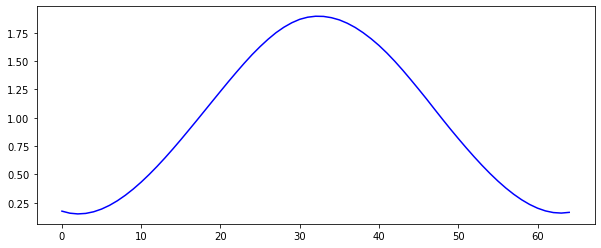

In [4]:
import numpy as np

# Generate synthetic test cases of 65-day LAI time series
days_year = np.linspace(0, 64, 65)
short_test_cases = []

# Case A: One growth season with logistic rise and fall
lai1 = (
    2.5 / (1 + np.exp(-0.2 * (days_65 - 20))) -
    2.5 / (1 + np.exp(-0.2 * (days_65 - 45))) +
    0.2 * np.random.normal(0, 1, len(days_65))
)
short_test_cases.append(lai1)

# Case B: Two quick growth bursts
lai2 = (
    1.5 / (1 + np.exp(-0.3 * (days_65 - 15))) +
    1.5 / (1 + np.exp(-0.3 * (days_65 - 50))) -
    1.5 / (1 + np.exp(-0.3 * (days_65 - 25))) -
    1.5 / (1 + np.exp(-0.3 * (days_65 - 60))) +
    0.1 * np.random.normal(0, 1, len(days_65))
)
short_test_cases.append(lai2)

# Case C: Gradual rise, plateau, and fall
lai3 = (
    2.0 / (1 + np.exp(-0.15 * (days_65 - 15))) -
    2.0 / (1 + np.exp(-0.15 * (days_65 - 55))) +
    0.15 * np.random.normal(0, 1, len(days_65))
)
short_test_cases.append(lai3)

# Case D: Very noisy with no clear seasonal trend
lai4 = 0.5 + 0.4 * np.random.normal(0, 1, len(days_65))
short_test_cases.append(lai4)

# Case E: Sharp peak in middle
lai5 = (
    3.0 * np.exp(-((days_65 - 32) ** 2) / (2 * 7 ** 2)) +
    0.1 * np.random.normal(0, 1, len(days_65))
)
short_test_cases.append(lai5)



from scipy.ndimage import uniform_filter1d

# Apply smoothing and re-run detection
smoothed_long_cases = [uniform_filter1d(lai, size=20) for lai in short_test_cases]


# Plotting smoothed LAI and detected transitions
for i, lai in enumerate(smoothed_long_cases):
    fig, ax = plt.subplots(figsize=(10, 4))
    lai = smooth_timeseries(lai)
    ax.plot(days_year, lai, label="Smoothed LAI", color='blue', linewidth=1.5)
    transitions, popt,  kvs = transition_dates(days_year, lai)

    print(len(kvs[0]))
    ax.plot(days_year, logistic(days_year, *popt))
    #ax.plot(days_year, kvs, label="curvature", color='black', linestyle='--',linewidth=1.5)
    for td in transitions:
        ax.axvline(td, color='red', linestyle='--', label=f"Transition @ {td:.1f}")
    ax.plot(days_year[:len(kvs[0])], normalize_timeseries_sklearn(kvs[0]), label="K'", color='black', linewidth=1.5)
    ax.plot(days_year[len(kvs[0])+1:], normalize_timeseries_sklearn(kvs[1]), label="K'", color='black', linewidth=1.5)
    ax.set_title(f"Smoothed 365-Day Test Case {chr(65 + i)}")
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("LAI")
    ax.legend()
    plt.tight_layout()
    break

plt.show()


ValueError: x and y must have same first dimension, but have shapes (65,) and (365,)

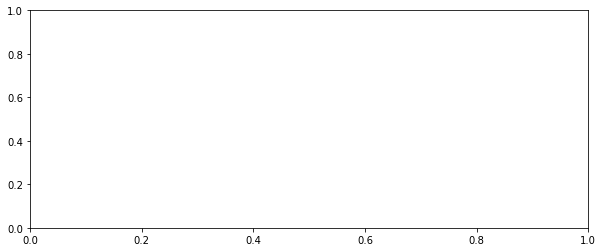

In [5]:
from scipy.ndimage import uniform_filter1d

# Apply smoothing and re-run detection
smoothed_long_cases = [uniform_filter1d(lai, size=20) for lai in long_test_cases]


# Plotting smoothed LAI and detected transitions
for i, lai in enumerate(smoothed_long_cases):
    fig, ax = plt.subplots(figsize=(10, 4))
    lai = smooth_timeseries(lai)
    ax.plot(days_year, lai, label="Smoothed LAI", color='blue', linewidth=1.5)
    transitions, popt,  kvs = transition_dates(days_year, lai)

    print(len(kvs[0]))
    ax.plot(days_year, logistic(days_year, *popt))
    #ax.plot(days_year, kvs, label="curvature", color='black', linestyle='--',linewidth=1.5)
    for td in transitions:
        ax.axvline(td, color='red', linestyle='--', label=f"Transition @ {td:.1f}")
    ax.plot(days_year[:len(kvs[0])], normalize_timeseries_sklearn(kvs[0]), label="K'", color='black', linewidth=1.5)
    ax.plot(days_year[len(kvs[0])+1:], normalize_timeseries_sklearn(kvs[1]), label="K'", color='black', linewidth=1.5)
    ax.set_title(f"Smoothed 365-Day Test Case {chr(65 + i)}")
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("LAI")
    ax.legend()
    plt.tight_layout()
    break

plt.show()


In [5]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, argrelextrema
from sklearn.preprocessing import MinMaxScaler

def normalize_series(series):
    series = np.asarray(series).reshape(-1, 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(series).flatten()

def smooth_series(series, window_length=11, polyorder=2):
    series = np.asarray(series)
    if len(series) < window_length:
        window_length = len(series) if len(series) % 2 else len(series)-1
    return savgol_filter(series, window_length, polyorder)

def logistic(t, a, b, c, d):
    return c / (1 + np.exp(a + b * t)) + d

def curvature_rate_of_change(t, a, b, c, d):
    z = np.exp(a + b * t)
    z1 = 1 - z
    z2 = 1 + z
    z3 = (b * c * z)**2
    partone_num = 3 * z * z1 * (z2**3) * (2 * (z2**3) + ((b**2) * (c**2) * z))
    partone_denom = ((z2**4 + z3)**(5/2))
    parttwo_num = z2**2 * (1 + 2*z - 5*z**2)
    parttwo_denom = (z2**4 + z3)**(3/2)
    difference = (partone_num / partone_denom) - (parttwo_num / parttwo_denom)
    return b**3 * c * z * difference

def detect_inflection_point(t, vi, threshold=0.005):
    t = np.array(t)
    vi = np.array(vi)

    # Normalize and smooth
    vi = normalize_series(vi)
    vi = smooth_series(vi)

    # Initial guess
    p0 = [-5, 0.1, max(vi) - min(vi), min(vi)]
    try:
        popt, _ = curve_fit(logistic, t, vi, p0, maxfev=10000)
        kv = curvature_rate_of_change(t, *popt)

        # Look for local maxima in rate of change of curvature
        extrema_indices = argrelextrema(kv, np.greater)[0]

        # If there’s a significant inflection, return True
        for idx in extrema_indices:
            if kv[idx] > threshold:
                return True  # Inflection point detected
    except Exception:
        pass

    return False  # No inflection detected

# Example usage:
# Simulated short VI time series (replace with real data)
np.random.seed(42)
days_65 = np.arange(65)
lai = 2.5 / (1 + np.exp(-0.15 * (days_65 - 30))) + 0.1 * np.random.randn(65)

inflection_detected = detect_inflection_point(days_65, lai)
print("Inflection point detected:", inflection_detected)


Inflection point detected: False


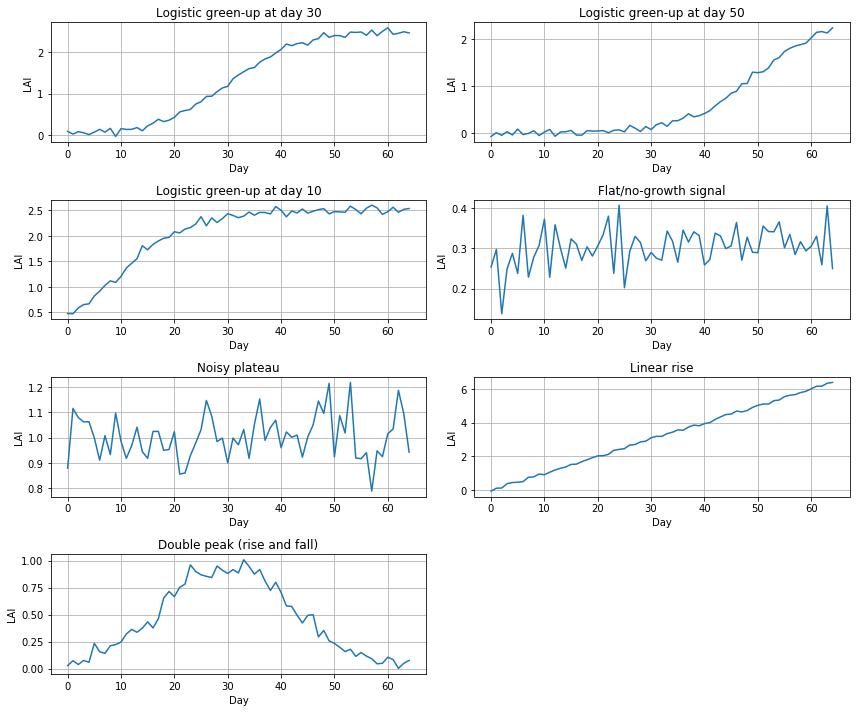

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic 65-day time series examples
def generate_test_series():
    days = np.arange(65)
    series_list = []
    labels = []

    # Case 1: Clear logistic green-up in mid-period
    lai1 = 2.5 / (1 + np.exp(-0.15 * (days - 30))) + 0.05 * np.random.randn(65)
    series_list.append(lai1)
    labels.append("Logistic green-up at day 30")

    # Case 2: Late green-up
    lai2 = 2.5 / (1 + np.exp(-0.15 * (days - 50))) + 0.05 * np.random.randn(65)
    series_list.append(lai2)
    labels.append("Logistic green-up at day 50")

    # Case 3: Early green-up
    lai3 = 2.5 / (1 + np.exp(-0.15 * (days - 10))) + 0.05 * np.random.randn(65)
    series_list.append(lai3)
    labels.append("Logistic green-up at day 10")

    # Case 4: Flat/no-growth series
    lai4 = 0.3 + 0.05 * np.random.randn(65)
    series_list.append(lai4)
    labels.append("Flat/no-growth signal")

    # Case 5: Noisy plateau
    lai5 = np.ones(65) * 1.0 + 0.1 * np.random.randn(65)
    series_list.append(lai5)
    labels.append("Noisy plateau")

    # Case 6: Gradual linear rise
    lai6 = 0.1 * days + 0.05 * np.random.randn(65)
    series_list.append(lai6)
    labels.append("Linear rise")

    # Case 7: Double peak
    lai7 = (
        1.5 / (1 + np.exp(-0.15 * (days - 20))) -
        1.5 / (1 + np.exp(-0.15 * (days - 40))) +
        0.05 * np.random.randn(65)
    )
    series_list.append(lai7)
    labels.append("Double peak (rise and fall)")

    return days, series_list, labels

# Plot the generated time series
days, test_series_list, test_labels = generate_test_series()
plt.figure(figsize=(12, 10))
for i, (lai, label) in enumerate(zip(test_series_list, test_labels)):
    plt.subplot(4, 2, i + 1)
    plt.plot(days, lai, label=label)
    plt.title(label)
    plt.xlabel("Day")
    plt.ylabel("LAI")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Use the previously defined detect_inflection_point function
# (Re-define here to run in this environment)

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, argrelextrema
from sklearn.preprocessing import MinMaxScaler

def normalize_series(series):
    series = np.asarray(series).reshape(-1, 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(series).flatten()

def smooth_series(series, window_length=11, polyorder=2):
    series = np.asarray(series)
    if len(series) < window_length:
        window_length = len(series) if len(series) % 2 else len(series)-1
    return savgol_filter(series, window_length, polyorder)

def logistic(t, a, b, c, d):
    return c / (1 + np.exp(a + b * t)) + d

def curvature_rate_of_change(t, a, b, c, d):
    z = np.exp(a + b * t)
    z1 = 1 - z
    z2 = 1 + z
    z3 = (b * c * z)**2
    partone_num = 3 * z * z1 * (z2**3) * (2 * (z2**3) + ((b**2) * (c**2) * z))
    partone_denom = ((z2**4 + z3)**(5/2))
    parttwo_num = z2**2 * (1 + 2*z - 5*z**2)
    parttwo_denom = (z2**4 + z3)**(3/2)
    difference = (partone_num / partone_denom) - (parttwo_num / parttwo_denom)
    return b**3 * c * z * difference

def detect_inflection_point(t, vi, threshold=0.005):
    t = np.array(t)
    vi = np.array(vi)

    # Normalize and smooth
    vi = normalize_series(vi)
    vi = smooth_series(vi)

    # Initial guess
    p0 = [-5, 0.1, max(vi) - min(vi), min(vi)]
    try:
        popt, _ = curve_fit(logistic, t, vi, p0, maxfev=10000)
        kv = curvature_rate_of_change(t, *popt)

        # Look for local maxima in rate of change of curvature
        extrema_indices = argrelextrema(kv, np.greater)[0]

        # If there’s a significant inflection, return True
        for idx in extrema_indices:
            if kv[idx] > threshold:
                return True  # Inflection point detected
    except Exception:
        pass

    return False  # No inflection detected

# Run detection on each series
inflection_results = []
for lai in test_series_list:
    result = detect_inflection_point(days, lai)
    inflection_results.append(result)

import pandas as pd

df_results = pd.DataFrame({
    "Case": test_labels,
    "Inflection Detected": inflection_results
})

df_results

,Case,Inflection Detected
0,Logistic green-up at day 30,False
1,Logistic green-up at day 50,False
2,Logistic green-up at day 10,False
3,Flat/no-growth signal,True
4,Noisy plateau,False
5,Linear rise,False
6,Double peak (rise and fall),True


In [10]:
# Modify the function to return the inflection date (first detected)
def detect_inflection_point_with_date(t, vi, threshold=0.005):
    t = np.array(t)
    vi = np.array(vi)

    # Normalize and smooth
    vi = normalize_series(vi)
    vi = smooth_series(vi)

    # Initial guess
    p0 = [-5, 0.1, max(vi) - min(vi), min(vi)]
    try:
        popt, _ = curve_fit(logistic, t, vi, p0, maxfev=10000)
        kv = curvature_rate_of_change(t, *popt)

        # Look for local maxima in rate of change of curvature
        extrema_indices = argrelextrema(kv, np.greater)[0]

        for idx in extrema_indices:
            if kv[idx] > threshold:
                return True, t[idx]  # Return detection and date
    except Exception:
        pass

    return False, None  # No inflection detected

# Run detection on each series with date
inflection_with_dates = []
for lai in test_series_list:
    result, date = detect_inflection_point_with_date(days, lai)
    inflection_with_dates.append((result, date))

# Prepare results
df_with_dates = pd.DataFrame({
    "Case": test_labels,
    "Inflection Detected": [r[0] for r in inflection_with_dates],
    "Inflection Day": [r[1] for r in inflection_with_dates]
})

df_with_dates

,Case,Inflection Detected,Inflection Day
0,Logistic green-up at day 30,False,NaN
1,Logistic green-up at day 50,False,NaN
2,Logistic green-up at day 10,False,NaN
3,Flat/no-growth signal,True,4.0
4,Noisy plateau,False,NaN
5,Linear rise,False,NaN
6,Double peak (rise and fall),True,48.0


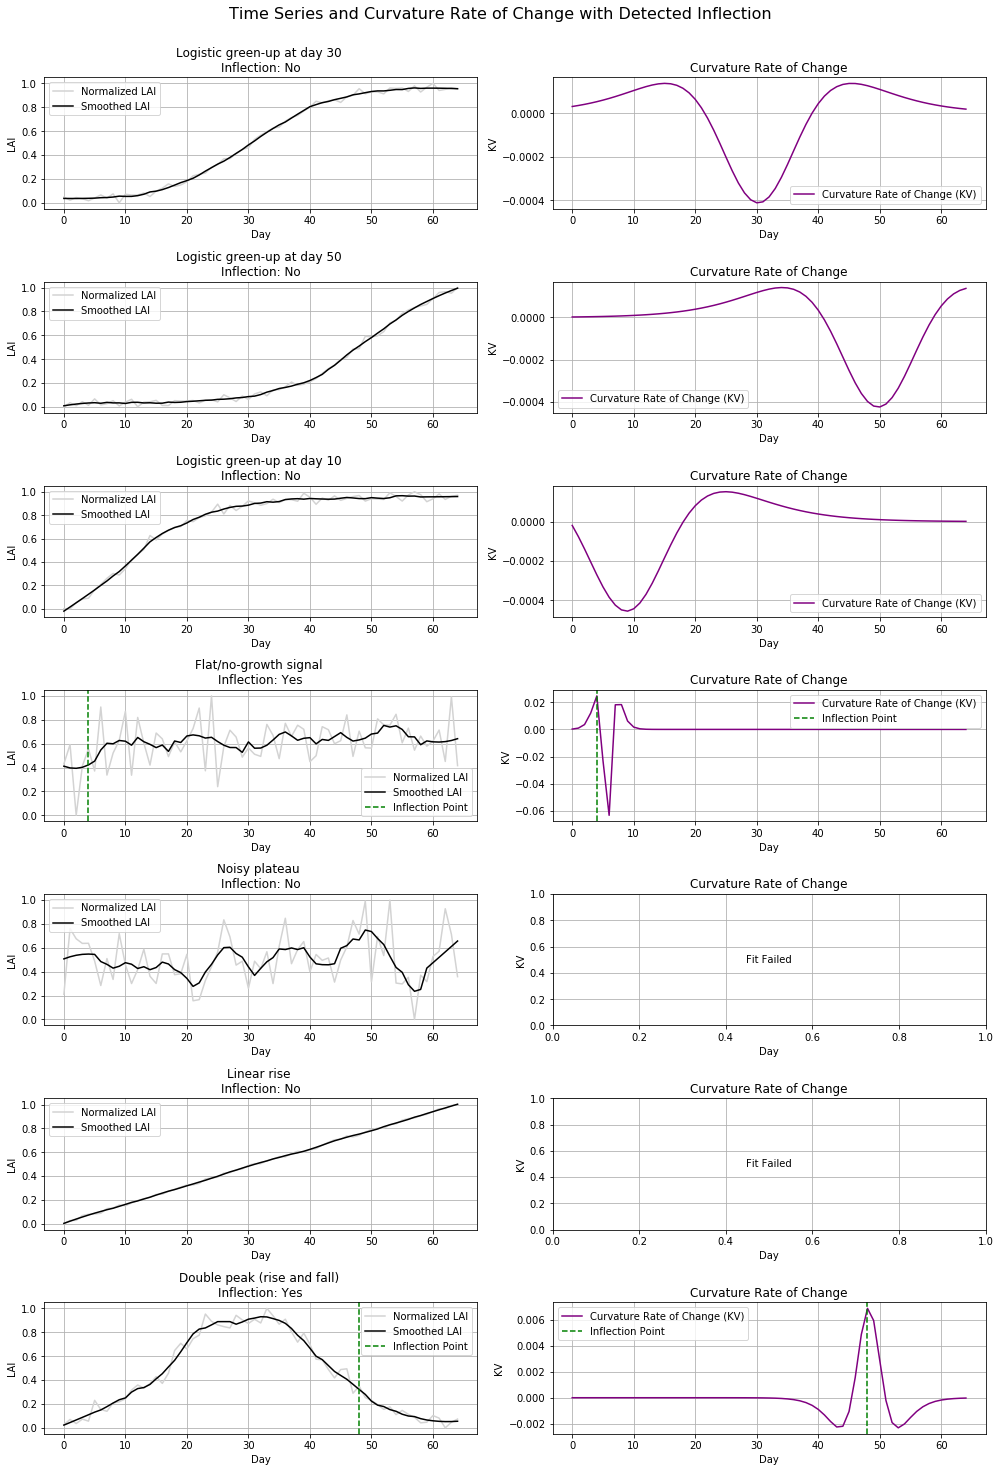

In [11]:
# Plot each time series, its smoothed version, the curvature rate of change, and the detected inflection point (if any)

fig, axs = plt.subplots(len(test_series_list), 2, figsize=(14, 20))
fig.suptitle("Time Series and Curvature Rate of Change with Detected Inflection", fontsize=16, y=1.02)

for i, (lai, label, (detected, inflection_day)) in enumerate(zip(test_series_list, test_labels, inflection_with_dates)):
    t = days
    vi = normalize_series(lai)
    smoothed_vi = smooth_series(vi)
    
    axs[i, 0].plot(t, vi, label="Normalized LAI", color='lightgray')
    axs[i, 0].plot(t, smoothed_vi, label="Smoothed LAI", color='black')
    if detected:
        axs[i, 0].axvline(x=inflection_day, color='green', linestyle='--', label="Inflection Point")
    axs[i, 0].set_title(f"{label} \nInflection: {'Yes' if detected else 'No'}")
    axs[i, 0].set_xlabel("Day")
    axs[i, 0].set_ylabel("LAI")
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # Curvature rate of change
    try:
        p0 = [-5, 0.1, max(smoothed_vi) - min(smoothed_vi), min(smoothed_vi)]
        popt, _ = curve_fit(logistic, t, smoothed_vi, p0, maxfev=10000)
        kv = curvature_rate_of_change(t, *popt)
        axs[i, 1].plot(t, kv, label="Curvature Rate of Change (KV)", color='purple')
        if detected:
            axs[i, 1].axvline(x=inflection_day, color='green', linestyle='--', label="Inflection Point")
        axs[i, 1].set_title("Curvature Rate of Change")
        axs[i, 1].set_xlabel("Day")
        axs[i, 1].set_ylabel("KV")
        axs[i, 1].legend()
        axs[i, 1].grid(True)
    except:
        axs[i, 1].text(0.5, 0.5, "Fit Failed", ha='center', va='center')
        axs[i, 1].set_title("Curvature Rate of Change")
        axs[i, 1].set_xlabel("Day")
        axs[i, 1].set_ylabel("KV")
        axs[i, 1].grid(True)

plt.tight_layout()
plt.show()
